#Downloading the dataset

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download kasikrit/att-database-of-faces
! unzip att-database-of-faces.zip -d ORL_Faces
dataset_dir = "ORL_Faces"

In [ ]:
import numpy as np
import sklearn as sk
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle
from sklearn import metrics
dataset_dir = "ORL_Faces"

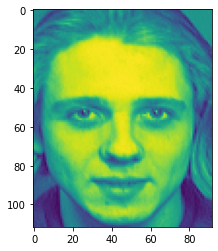

In [ ]:
path = dataset_dir + "/s12/1.pgm"
try:  
    img  = Image.open(path) 
    plt.imshow(img)
except IOError: 
    pass

#Forming the data matrix D and label vector Y

In [ ]:
y = []
D = []

def img_to_vector(filename):
    img  = Image.open(filename).resize((112, 92))
    img_vector = np.array(img).flatten()
    return img_vector


for i in range(40):
  person_id = i+1
  for j in range(10):
    path = dataset_dir + '/s'+str(person_id)+'/'+str(j+1)+'.pgm'
    row = img_to_vector(path).astype(np.int64) 
    D.append(row)
    y.append(person_id)
y = np.asarray(y)
D = np.asarray(D)

#Splitting the data matrix and label vector into train and test sets

In [ ]:
d_train = D[::2]
y_train = y[::2]
d_test = D[1::2]
y_test = y[1::2]

d_train, y_train = shuffle(d_train, y_train)
d_test, y_test = shuffle(d_test, y_test)

#PCA

In [ ]:

mean = np.mean(d_train, axis=0)
d_train = d_train - mean

mean = np.mean(d_test, axis=0)
d_test = d_test - mean


cov = np.cov(d_train, bias = True, rowvar = False)
eigvals, eigvecs = np.linalg.eigh(cov)
idx = eigvals.argsort()[::-1]  
eigvals = eigvals[idx]
eigvecs = eigvecs[:,idx]



In [ ]:
def PCA (alpah_vals, K, show):
  acc_vals = []
  for alpha in alpha_vals:
    r = 0
    while ( (np.sum(eigvals[0:r]) / np.sum(eigvals)) - alpha <= 1e-8):
      r+= 1

    projected_train = d_train @ eigvecs[:, :r]
    projected_test =  d_test @ eigvecs[:, :r]
    knnc = KNeighborsClassifier(n_neighbors=K)
    knnc.fit(projected_train,y_train)
    y_predicted = knnc.predict(projected_test)
    acc = metrics.accuracy_score(y_test,y_predicted)
    if(show):
      print("Alpha = ", alpha)
      print("r = ", r)
      print("Accuracy = ", acc)
      print("\n\n")
    acc_vals.append(acc)
  if(show):
    plt.scatter(alpha_vals, acc_vals)
    plt.xlabel("Alpha")
    plt.ylabel("Accuracy")
    plt.title("PCA Alpha VS Accuracy At K = " + str(K))
    plt.show()
  return max(acc_vals)

#PCA Classifying at K = 1

Alpha =  0.8
r =  33
Accuracy =  0.945



Alpha =  0.85
r =  48
Accuracy =  0.95



Alpha =  0.9
r =  71
Accuracy =  0.94



Alpha =  0.95
r =  110
Accuracy =  0.94





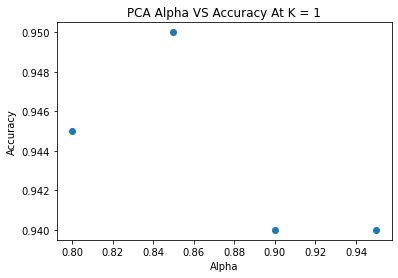

Best accuaracy at K = 1 is: 0.95


In [ ]:
alpha_vals = [0.8,0.85,0.9,0.95]
K = 1
acc = PCA(alpha_vals, K, show = True)
print("Best accuaracy at K = "+ str(K)  + " is: " + str(acc) )

#PCA Classifier Tuning

PCA K vs Accuracy Plot



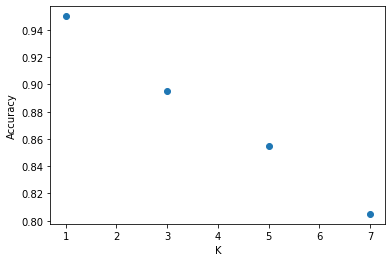

In [ ]:
K_vals = [1,3,5,7]
alpha_vals = [0.8,0.85,0.9,0.95]
acc_vals = []

for K in K_vals:
  acc_vals.append(PCA(alpha_vals, K, show = False))
print("PCA K vs Accuracy Plot\n")
plt.scatter(K_vals, acc_vals)
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.title("K Alpha VS Accuracy at best alpha for each K")
plt.show()

#LDA Classifying at K = 1

In [ ]:
mean_vector = np.mean(d_train, axis=0)
x,n=np.unique(y_train,return_counts=True)
mean_vector_class=np.zeros((len(n),d_train.shape[1]))
data_centered_classes=np.zeros((d_train.shape[0],d_train.shape[1]))

S_t=np.zeros((d_train.shape[1],d_train.shape[1]))
B=np.zeros((d_train.shape[1],d_train.shape[1]))

for i in range (len(n)):
    mean_vector_class[i]=np.mean(d_train[np.sum(n[0:i]):np.sum(n[0:i+1])],axis=0) # class means
    B=B+n[i]*np.matmul((mean_vector_class[i]-mean_vector).T,(mean_vector_class[i]-mean_vector)) #between class scatter matrix
    data_centered_classes[np.sum(n[0:i]):np.sum(n[0:i+1])]=d_train[np.sum(n[0:i]):np.sum(n[0:i+1])]-mean_vector_class[i]  #center class matrices
    S=np.matmul((data_centered_classes[np.sum(n[0:i]):np.sum(n[0:i+1])]).T,data_centered_classes[np.sum(n[0:i]):np.sum(n[0:i+1])])  #class scatter matrices
    S_t=S_t+S

#compute dominant eigenvector
eigen_values, U = np.linalg.eigh(np.dot(np.linalg.inv(S_t),B))
index = np.argsort(eigen_values)[::-1]
sorted_eigenvectors = U[:,index]
eigenvectors=sorted_eigenvectors[:,0:39]
eigenvectors = np.real(eigenvectors)
projected_train = (np.matmul(eigenvectors.T, d_train.T)).T
projected_test = (np.matmul(eigenvectors.T, d_test.T)).T
knnc = KNeighborsClassifier(n_neighbors=1)
knnc.fit(projected_train,y_train)
y_predicted = knnc.predict(projected_test)
acc = metrics.accuracy_score(y_test,y_predicted)
print("Accuracy = ", acc)
print("\n\n")

Accuracy =  0.935





In [ ]:
def LDA_KNNC (K):
  knnc = KNeighborsClassifier(n_neighbors=K)
  knnc.fit(projected_train,y_train)
  y_predicted = knnc.predict(projected_test)
  acc = metrics.accuracy_score(y_test,y_predicted)
  print("Accuracy = ", acc)
  print("\n\n")
  return acc

#LDA Classifier Tuning

Accuracy =  0.935



Accuracy =  0.87



Accuracy =  0.79



Accuracy =  0.72



LDA K vs Accuracy Plot



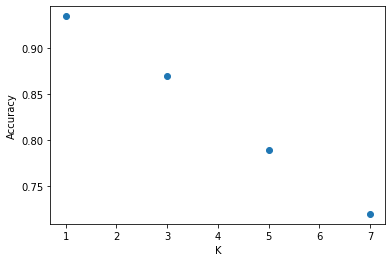

In [ ]:
K_vals = [1,3,5,7]
acc_vals = []

for K in K_vals:
  acc_vals.append(LDA_KNNC(K))
print("LDA K vs Accuracy Plot\n")
plt.scatter(K_vals, acc_vals)
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.show()